In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sectionate as sec
import regionate as reg
import pyhodge as ph

import xplocean as xpl

In [15]:
import cmocean

In [5]:
import pickle
BasinsFile = "/work/hfd/datasets/regionate/pickled_regions/PJ2010_region_gridded_CM4p25_moc"
with open(BasinsFile, 'rb') as pickle_file:
    region = pickle.load(pickle_file)

In [6]:
# sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
# zdiag_path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2/"
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p25/c192_OM4_025_grid_No_mg_drag_v20160808_unpacked/ocean_hgrid.nc")
zdiag_path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7_allfixes/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2/"
og = xr.open_dataset(f"{zdiag_path}ocean_annual_rho2.static.nc")
og = og.assign_coords({'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
                                       'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])})
A = og['areacello']
symmetric = og.geolon.shape != og.geolon_c.shape

rho0 = 1035.

### Find basin centroids and edge centers

In [7]:
def get_vertices_and_edge_coordinates(E, region, extrapolate_vertices=None):
    V = {}
    E_coords = {}
    for e, ((b1name, b2name), x) in enumerate(E.items()):
        b1 = region.Basins[b1name]
        b2 = region.Basins[b2name]
        
        o1 = [oooo for ooo in region.overlaps[(b1name, b2name)][b1name].values() for oooo in ooo]
        lon1_e = b1.lons_uv[o1[len(o1)//2]]
        lat1_e = b1.lats_uv[o1[len(o1)//2]]

        o2 = [oooo for ooo in region.overlaps[(b1name, b2name)][b2name].values() for oooo in ooo]
        lon2_e = b2.lons_uv[o2[len(o2)//2]]
        lat2_e = b2.lats_uv[o2[len(o2)//2]]
        
        lon1_av = reg.lon_mod(b1.mask.geolon.where(b1.mask), lon1_e).weighted(A).mean().values
        lat1_av = b1.mask.geolat.where(b1.mask).weighted(A).mean().values

        lon2_av = reg.lon_mod(b2.mask.geolon.where(b2.mask), lon2_e).weighted(A).mean().values
        lat2_av = b2.mask.geolat.where(b2.mask).weighted(A).mean().values
        
        if b1.name in extrapolate_vertices:
            δlon = lon2_e - lon2_av
            δlat = lat2_e - lat2_av
            lon1_av = lon1_e + δlon/5
            lat1_av = lat1_e + δlat/5
        elif b2.name in extrapolate_vertices:
            δlon = lon1_e - lon1_av
            δlat = lat1_e - lat1_av
            lon2_av = lon2_e + δlon/5
            lat2_av = lat2_e + δlat/5
            
        V[b1name] = (lon1_av, lat1_av)
        V[b2name] = (lon2_av, lat2_av)
        E_coords[(b1name, b2name)] = ( ([lon1_av, lon1_e], [lat1_av, lat1_e]), ([lon2_e, lon2_av], [lat2_e, lat2_av]) )
        
    return V, E_coords

In [8]:
def overturning_circulation_graph(region, rho2_i, round_digits=6, land_vertices=None):
    E = {o:np.round(region.Basins[o[1]].psi_exchange[o].mean('time').sel(rho2_i=rho2_i, method="nearest").values, round_digits) for o in region.overlaps.keys()}
    E = {e:x for (e,x) in E.items() if x!=0.}
    V, E_coords = get_vertices_and_edge_coordinates(E, region, extrapolate_vertices=land_vertices)
    G = ph.GraphFlow(V, E)
    decompose_overturning(G, land_vertices=land_vertices)
    G.E_coords = E_coords
    G.land_vertices = land_vertices
    
    return G

In [12]:
def decompose_overturning(G, land_vertices=None):
    Voce, Eoce = (
        {k:v for (k,v) in G.V.items() if  k    not in land_vertices},
        {k:v for (k,v) in G.E.items() if (k[0] not in land_vertices) and (k[1] not in land_vertices)}
    )
    Goce = ph.GraphFlow(Voce, Eoce)
    ph.decompose_graph_flow(Goce)

    G.Xdiv = G.X.copy()
    G.Xloc = np.zeros_like(G.X)
    G.Xnl = np.zeros_like(G.X)
    G.Xrot = np.zeros_like(G.X)
    for e, (v1,v2) in enumerate(Goce.E.keys()):
        G.Xdiv[list(G.E).index((v1, v2))] = Goce.Xdiv[e]
        G.Xloc[list(G.E).index((v1, v2))] = Goce.Xloc[e]
        G.Xnl[list(G.E).index((v1, v2))] = Goce.Xnl[e]
        G.Xrot[list(G.E).index((v1, v2))] = Goce.Xrot[e]

In [16]:
def plot_global_graph_flow(R, G, component='X', ax=None, pcolorflag=True):
    if ax is None:
        ax=plt.gca()
        
    if pcolorflag:
        cmap = cmocean.cm.deep.copy()
        cmap.set_bad((0.8, 0.8, 0.8))
        ax.set_facecolor((0.8, 0.8, 0.8))
        ax.set_xlim(-305, 65)

        for x_mod in [-360, 0, 360]:
            ax.pcolormesh(
                og['geolon_c']+x_mod, og['geolat_c'],
                og['deptho'],
                cmap=cmap,
                vmin=0, vmax=10000
            )
        
    for x_mod in [-360, 0, 360]:
        # Basin boundaries
        for b in R.Basins.values():
            ax.plot(b.lons+x_mod, b.lats, ".", markersize=0.1, color=xpl.make_color_transparent("k", 0.925))
            
    X = getattr(G, component)
    Xmax = max(np.max(np.abs(X)), 1.e-1)
    norm = 1/(Xmax/30.)
    for x_mod in [-360, 0, 360]:
        # Transports along graph edges (with an elbow at the center of boundaries)
        for e, ((b1name, b2name), x) in enumerate(zip(G.E.keys(), X)):
            E_coord = G.E_coords[(b1name, b2name)]
            l=xpl.transport_vector(fig, ax, E_coord[0][0][0]+x_mod, E_coord[0][1][0], E_coord[0][0][1]+x_mod, E_coord[0][1][1], flow=x*norm, color=xpl.make_color_transparent((0., 0., 0.5), 0.85))
            xpl.transport_vector(fig, ax, E_coord[1][0][0]+x_mod, E_coord[1][1][0], E_coord[1][0][1]+x_mod, E_coord[1][1][1], flow=x*norm, color=l[0].get_color())
            if np.abs(x)>0.25:
                ax.annotate(str(np.round(np.abs(x),1)), (E_coord[0][0][1]+x_mod, E_coord[0][1][1]), color="w", ha="center", va="center", fontsize=8, weight="bold")
            
    for x_mod in [-360, 0, 360]:
        # Divergence at graph vertices (centroid coordinate of the basin)
        D = ph.div(G.E, G.V)@X
        for b in region.Basins.values():
            if (b.name in G.land_vertices) or (b.name not in G.V): continue
            xpl.normal_vector(fig, ax, (G.V[b.name][0]+x_mod, G.V[b.name][1]), -D[list(G.V).index(b.name)], scale=2.5)
         
    for flow_label in 2**np.arange(np.ceil(np.log2(Xmax))-4, np.ceil(np.log2(Xmax))+1, 2.):
        xpl.transport_vector(fig, ax, np.nan, np.nan, np.nan, np.nan, flow=flow_label*norm, color="k", label=f"{flow_label} Sv")
        
    ax.legend(loc="upper left")
    ax.set_ylim(-82, 72)

In [17]:
for rho2_i in region.Basins['1'].psi_net.rho2_i.values:
    G = overturning_circulation_graph(region, rho2_i=rho2_i, land_vertices=['34', '35', '36'])
    
    fig, ax = plt.subplots(num=1, figsize=(14, 6.25))
    plot_global_graph_flow(region, G, component='X', ax=ax)
    ax.set_title(fr"Circulation pathways of water denser than $\rho_{{2}} = ${rho2_i}")
    plt.savefig(f"../figures/global_circulation_timemean/rho2_i={rho2_i}.png", bbox_inches="tight", dpi=150.)
    plt.clf()
    break

<Figure size 1400x625 with 0 Axes>

In [18]:
rho2_i = 1037.1
G = overturning_circulation_graph(region, rho2_i=rho2_i, land_vertices=['34', '35', '36'])

Text(0.5, 1.0, 'Non-local recirculations below $\\rho_{2} = 1037.1$')

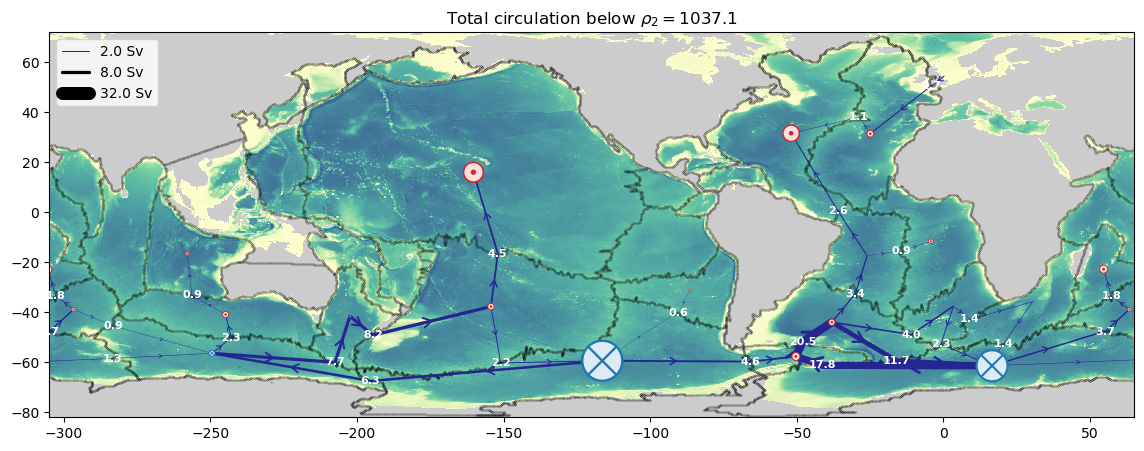

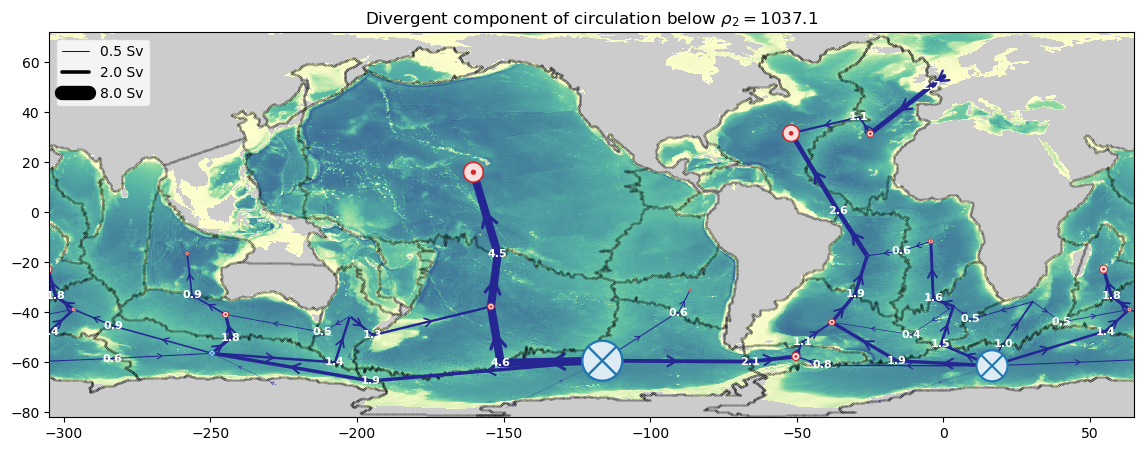

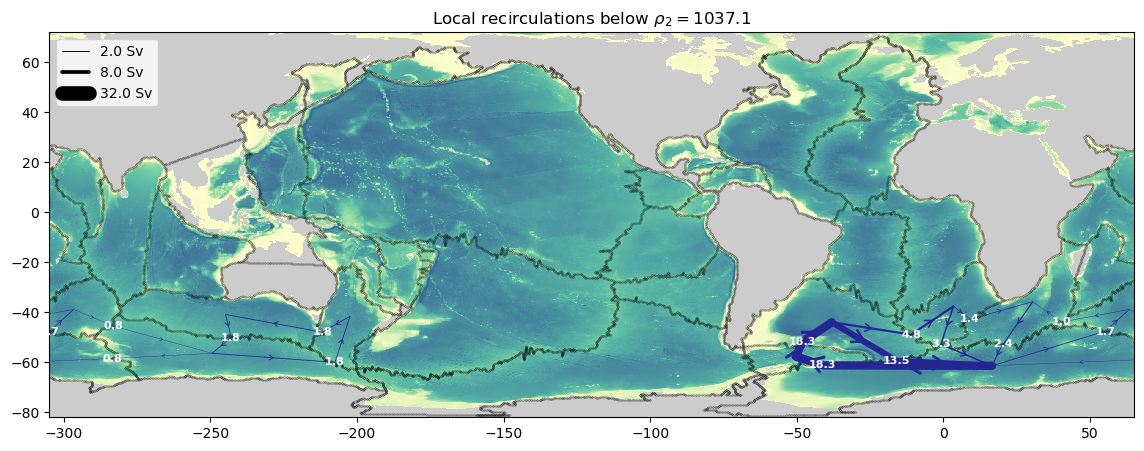

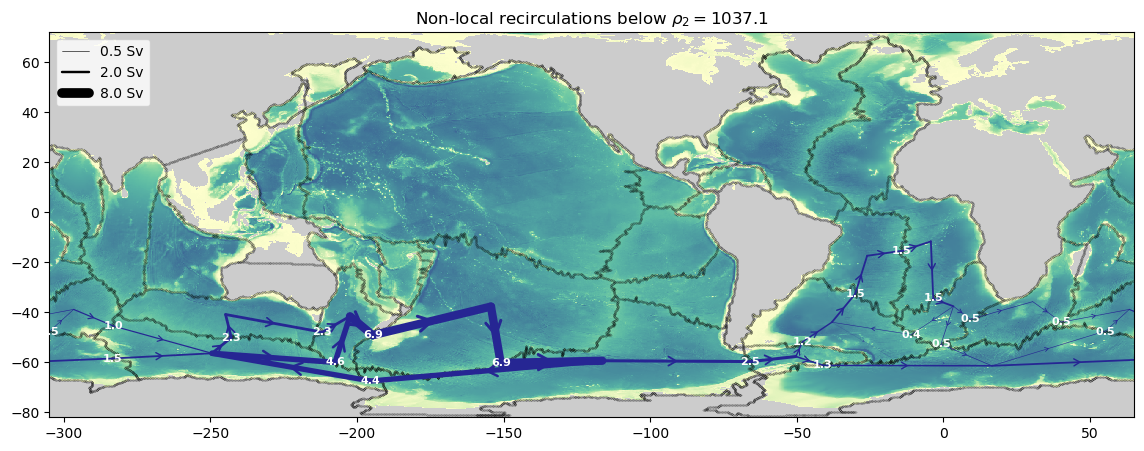

In [19]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_global_graph_flow(region, G, component='X', ax=ax)
ax.set_title(fr"Total circulation below $\rho_{{2}} = {rho2_i}$")

fig, ax = plt.subplots(figsize=(14, 5))
plot_global_graph_flow(region, G, component='Xdiv', ax=ax)
ax.set_title(fr"Divergent component of circulation below $\rho_{{2}} = {rho2_i}$")

fig, ax = plt.subplots(figsize=(14, 5))
plot_global_graph_flow(region, G, component='Xloc', ax=ax)
ax.set_title(fr"Local recirculations below $\rho_{{2}} = {rho2_i}$")

fig, ax = plt.subplots(figsize=(14, 5))
plot_global_graph_flow(region, G, component='Xnl', ax=ax)
ax.set_title(fr"Non-local recirculations below $\rho_{{2}} = {rho2_i}$");

### Analyze inter-basin transports

In [17]:
b = region.Basins['24']

### Full boundary

In [18]:
Ψ = b.psi.isel(rho2_l=-1)

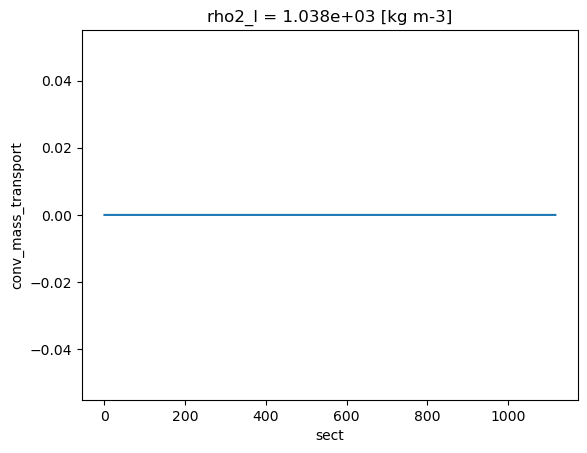

In [19]:
Ψ.cumsum('sect').plot()

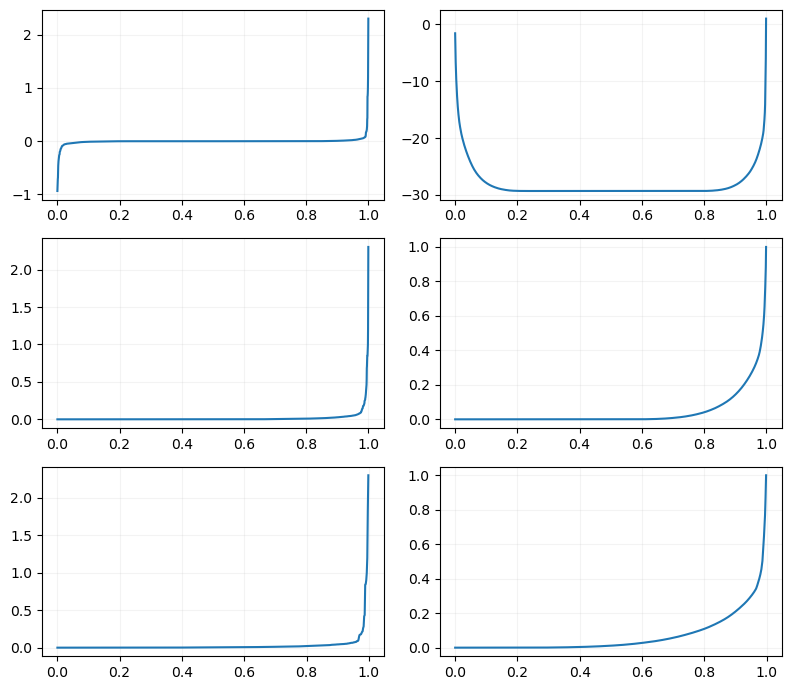

In [235]:
fig, axes = plt.subplots(3,2, figsize=(8, 7))

Ψsorted = Ψ.sortby(Ψ)
axes[0,0].plot(np.arange(0, Ψsorted.size)/Ψsorted.size, Ψsorted)
axes[0,1].plot(np.arange(0, Ψsorted.size)/Ψsorted.size, Ψsorted.cumsum('sect') / Ψsorted.sum('sect'))

Ψabs_sorted = np.abs(Ψ).sortby(np.abs(Ψ))
axes[1,0].plot(np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, Ψabs_sorted)
axes[1,1].plot(np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, Ψabs_sorted.cumsum('sect') / Ψabs_sorted.sum('sect'))

idx = Ψsorted>0.
Ψsorted_in = Ψsorted[idx]
axes[2,0].plot(np.arange(0, Ψsorted_in.size)/Ψsorted_in.size, Ψsorted_in)
axes[2,1].plot(np.arange(0, Ψsorted_in.size)/Ψsorted_in.size, Ψsorted_in.cumsum('sect')/Ψsorted_in.sum('sect'))

for ax in axes.flatten():
    ax.grid(True, alpha=0.15)

plt.tight_layout()

### Inter-basin boundary

In [236]:
Ψ = b.psi.isel(sect=reg.flatten_odict(region.overlaps[('23', '24')]['24'])).isel(rho2_l=-1)

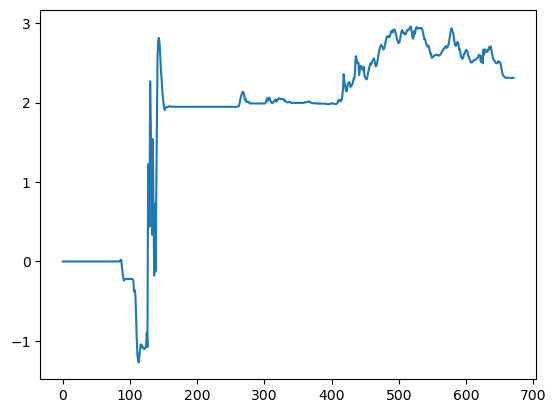

In [239]:
plt.plot(Ψ.cumsum('sect'))

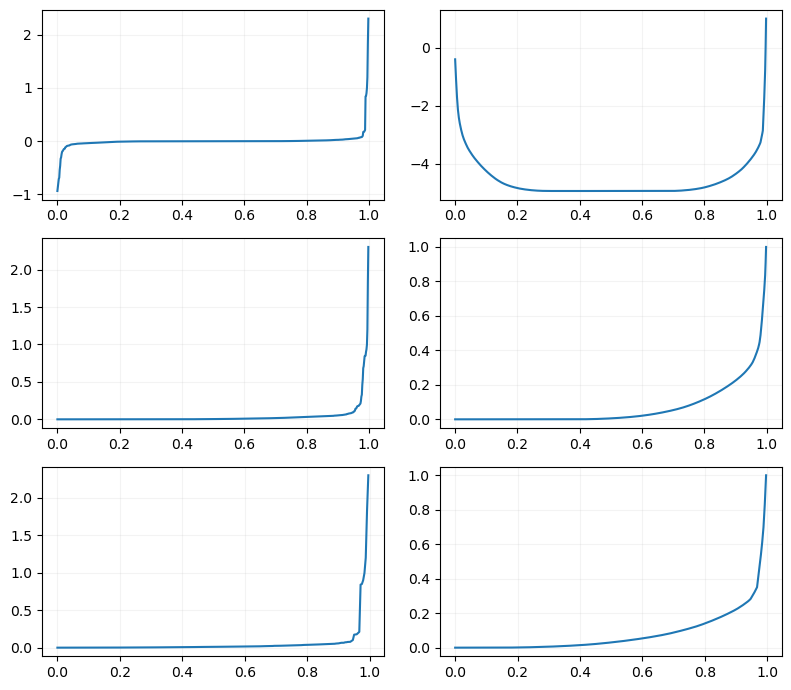

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(8, 7))

for ax in axes.flatten():
    ax.grid(True, alpha=0.15)
    ax.plot([0,0], [1,1], "k--", alpha=0.5, lw=1.5)

Ψsorted = Ψ.sortby(Ψ)
axes[0,0].plot(np.arange(0, Ψsorted.size)/Ψsorted.size, Ψsorted)
axes[0,1].plot(np.arange(0, Ψsorted.size)/Ψsorted.size, Ψsorted.cumsum('sect') / Ψsorted.sum('sect'))

Ψabs_sorted = np.abs(Ψ).sortby(np.abs(Ψ))
axes[1,0].plot(np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, Ψabs_sorted)
axes[1,1].plot(np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, Ψabs_sorted.cumsum('sect') / Ψabs_sorted.sum('sect'))

idx = Ψsorted>0.
Ψsorted_in = Ψsorted[idx]
axes[2,0].plot(np.arange(0, Ψsorted_in.size)/Ψsorted_in.size, Ψsorted_in)
axes[2,1].plot(np.arange(0, Ψsorted_in.size)/Ψsorted_in.size, Ψsorted_in.cumsum('sect')/Ψsorted_in.sum('sect'))

plt.tight_layout()

In [259]:
# Percent of faces along boundary that contributes to net transport
(Ψsorted.size - (((Ψsorted.cumsum('sect') / Ψsorted.sum('sect')) > 0).argmax('sect'))) / Ψsorted.size*100

<xarray.DataArray 'conv_mass_transport' ()>
array(0.29761905)
Coordinates:
    rho2_l   float64 1.039e+03
    time     object 0350-07-02 12:00:00

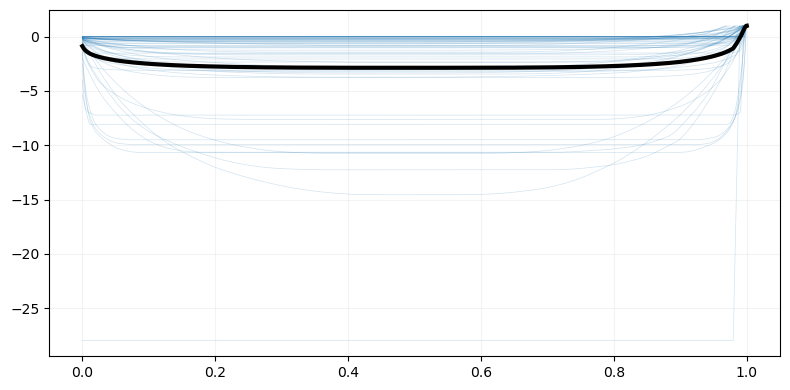

In [73]:
fig, ax = plt.subplots(1,1,figsize=(8, 4))

ax.grid(True, alpha=0.15)
#ax.plot([0,1], [0,1], "k--", alpha=0.5, lw=1.5)
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)

dx = 1.e-3
x = np.arange(0., 1.+dx, dx)
y = np.zeros_like(x)
R = []

N = 0

for oname, o in region.overlaps.items():
    Ψ = cumsum_rev(region.Basins[oname[0]].psi.isel(sect=reg.flatten_odict(o[oname[0]])), "rho2_l").sel(rho2_l=1037.05, method="nearest")
    
    Ψ = Ψ/np.sign(Ψ.sum("sect"))
    Ψsorted = Ψ.sortby(Ψ)
    xp = np.arange(0, Ψsorted.size)/Ψsorted.size
    yp = (Ψsorted.cumsum('sect')/Ψsorted.cumsum('sect').isel(sect=-1))
    if not(np.any(np.isnan(yp.values))):
        ax.plot(xp, yp, "C0-", alpha=0.2, lw=0.5)
        y += np.interp(x, xp, yp)
        N += 1
        R.append(np.max(-yp))
R = np.array(R)
y = y/N

plt.plot(x, y, "k-", lw=3)
plt.tight_layout()

(0.0, 27.983007944325674)

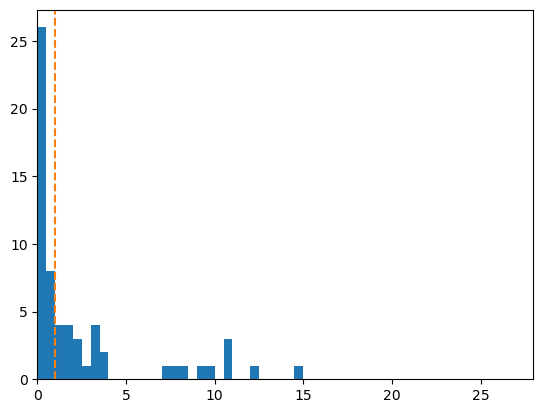

In [70]:
plt.hist(R, bins=np.arange(0., 20, 0.5))
plt.axvline(1., color="C1", lw=1.5, ls="--")
plt.xlim(0, np.max(R))

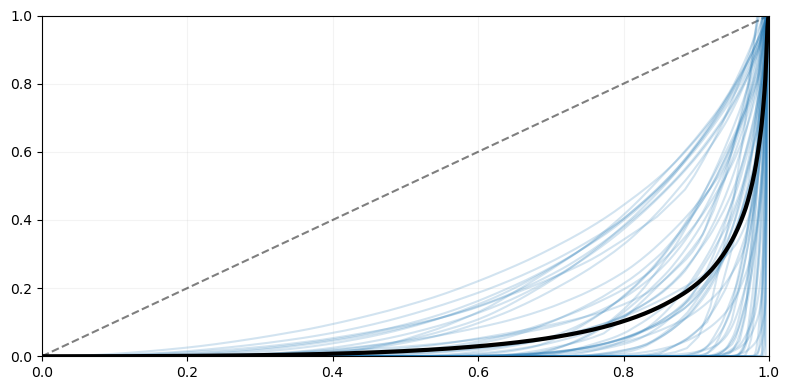

In [309]:
fig, ax = plt.subplots(1,1,figsize=(8, 4))

ax.grid(True, alpha=0.15)
ax.plot([0,1], [0,1], "k--", alpha=0.5, lw=1.5)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

dx = 1.e-3
x = np.arange(0., 1.+dx, dx)
N = 0
y = np.zeros_like(x)
    
for oname, o in region.overlaps.items():
    Ψ = region.Basins[oname[0]].psi.isel(sect=reg.flatten_odict(o[oname[0]])).isel(rho2_l=-1)
    
    Ψsorted = Ψ.sortby(Ψ)
    Ψabs_sorted = np.abs(Ψ).sortby(np.abs(Ψ))
    ax.plot(np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, Ψabs_sorted.cumsum('sect')/Ψabs_sorted.sum('sect'), "C0-", alpha=0.2)
    if not(np.any(np.isnan((Ψabs_sorted.cumsum('sect')/Ψabs_sorted.sum('sect')).values))):
        y += np.interp(x, np.arange(0, Ψabs_sorted.size)/Ψabs_sorted.size, (Ψabs_sorted.cumsum('sect')/Ψabs_sorted.sum('sect')).values)
        N += 1
y = y/N
    
plt.plot(x, y, "k-", lw=3)
plt.tight_layout()